## Import Necessary Packages

In [1]:
import glob
import numpy as np
import xarray as xr
from scipy import interpolate
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import proplot as pplt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
path  = '/ocean/projects/atm200007p/'
e3sm  = np.squeeze(xr.open_dataset(path+'sferrett/e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc'))
era5  = xr.open_dataset(path+'sferrett/era5/ERA5_2D_195906_202108_monthly.nc')
era5  = era5.reindex(latitude=era5.latitude[::-1]).rename({'longitude':'lon','latitude':'lat'})
imerg = xr.open_mfdataset(np.sort(glob.glob(path+'nanaliu/imerg/'+'*.nc4'))).transpose('time','lat','lon')

## Standardize Data and Define Variables

In [3]:
lat1=10; lat2=20; lon1=60; lon2=73.6
z   = e3sm.PHIS.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')/9.80665/1000
lon = e3sm.lon.sel(lon=slice(lon1,lon2))
months = ['JUN','JUL','AUG']
names  = ['ERA5 (1959 - 2021)','IMERG (2000 - 2021)']
era5years  = 63
imergyears = 22

In [4]:
def transformlon(londata,prdata):
    lonslice  = londata.sel(lon=slice(lon1,lon2)).to_numpy()
    prprofile = prdata.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)).mean(dim='lat').to_numpy()
    transform = interpolate.interp1d(lonslice,prprofile,bounds_error=False)
    return transform(lon)
era5precip  = xr.DataArray(transformlon(era5.lon,era5.mtpr))*86400
imergprecip = xr.DataArray(transformlon(imerg.lon,imerg.precipitation))*24
era5pr  = xr.concat((era5precip[0::3],era5precip[1::3],era5precip[2::3]),dim='time')
imergpr = xr.concat((imergprecip[0::12],imergprecip[1::12],imergprecip[2::12]),dim='time')

## Plot Upwind Profile of Precipitation

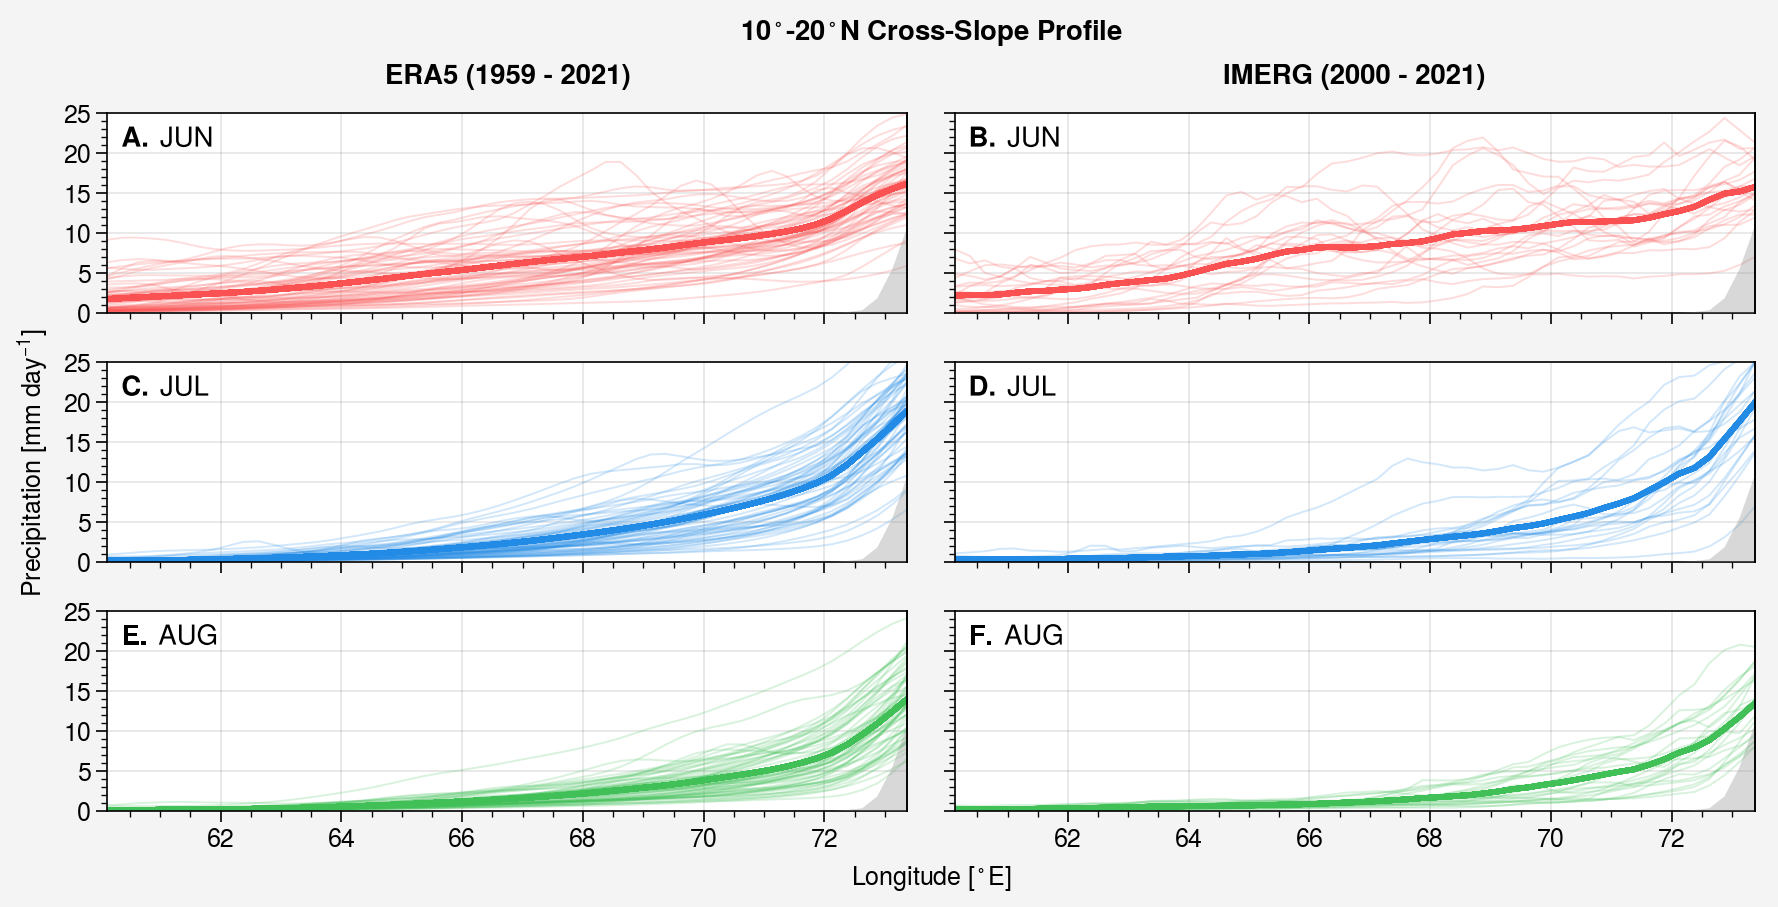

In [5]:
pplt.rc.reso='hi'; colors=np.asarray(['red6','blue6','green6']); alpha=0.2; linewidth=np.asarray([0.7,2])
fig,axs = pplt.subplots(ncols=2,nrows=3,refwidth=4,refheight=1)
axs.format(suptitle=str(lat1)+'$^\circ$-'+str(lat2)+'$^\circ$N Cross-Slope Profile',
           abc='A.',abcloc='ul',collabels=names,
           xlabel='Longitude [$^\circ$E]',xticks=2,
           ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,25),yticks=5) 
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylim=(0,0.2),ylabel='',yticks='null')
for i,ax in enumerate(months): 
    for j in range(era5years):
        axs[2*i].plot(lon,era5pr[i,j],colors=colors[i],alpha=alpha,linewidth=linewidth[0])
        axs[2*i].plot(lon,era5pr[i].mean(axis=0),colors=colors[i],linewidth=linewidth[1])
        axs[2*i].format(titleloc='ul',title=months[i])
    for k in range(imergyears):
        axs[2*i+1].plot(lon,imergpr[i,k],colors=colors[i],alpha=alpha,linewidth=linewidth[0])
        axs[2*i+1].plot(lon,imergpr[i].mean(axis=0),colors=colors[i],linewidth=linewidth[1])
        axs[2*i+1].format(titleloc='ul',title=months[i])

## Plot Exponential Fits of Upwind Precipitation

In [6]:
p0=(1,-0.005); maxfev=10000; era5params=[]; era5fittedpr=[]; imergparams=[]; imergfittedpr=[]
def exponential(x,a,b): return a*np.exp(b*x)
for i,ax in enumerate(months):    
    params=[]
    fittedpr=[]
    for j in range(era5years):
        coeffs,_ = curve_fit(exponential,lon,era5pr[i][j],p0=p0,maxfev=maxfev)
        a,b = coeffs[0],coeffs[1]
        params.append(coeffs)
        fittedpr.append(a*np.exp(b*lon))
    era5params.append(params)
    era5fittedpr.append(fittedpr)
    params=[]
    fittedpr=[]      
    for k in range(imergyears):
        coeffs,_ = curve_fit(exponential,lon,imergpr[i][k],p0=p0,maxfev=maxfev)
        a,b = coeffs[0],coeffs[1]
        params.append(coeffs)
        fittedpr.append(a*np.exp(b*lon))
    imergparams.append(params)
    imergfittedpr.append(fittedpr)
era5params    = xr.DataArray(era5params).rename({'dim_0':'months','dim_1':'years','dim_2':'params'})
imergparams   = xr.DataArray(imergparams).rename({'dim_0':'months','dim_1':'years','dim_2':'params'})
era5fittedpr  = xr.DataArray(era5fittedpr).rename({'dim_0':'months','dim_1':'years','dim_2':'lon'})
imergfittedpr = xr.DataArray(imergfittedpr).rename({'dim_0':'months','dim_1':'years','dim_2':'lon'})

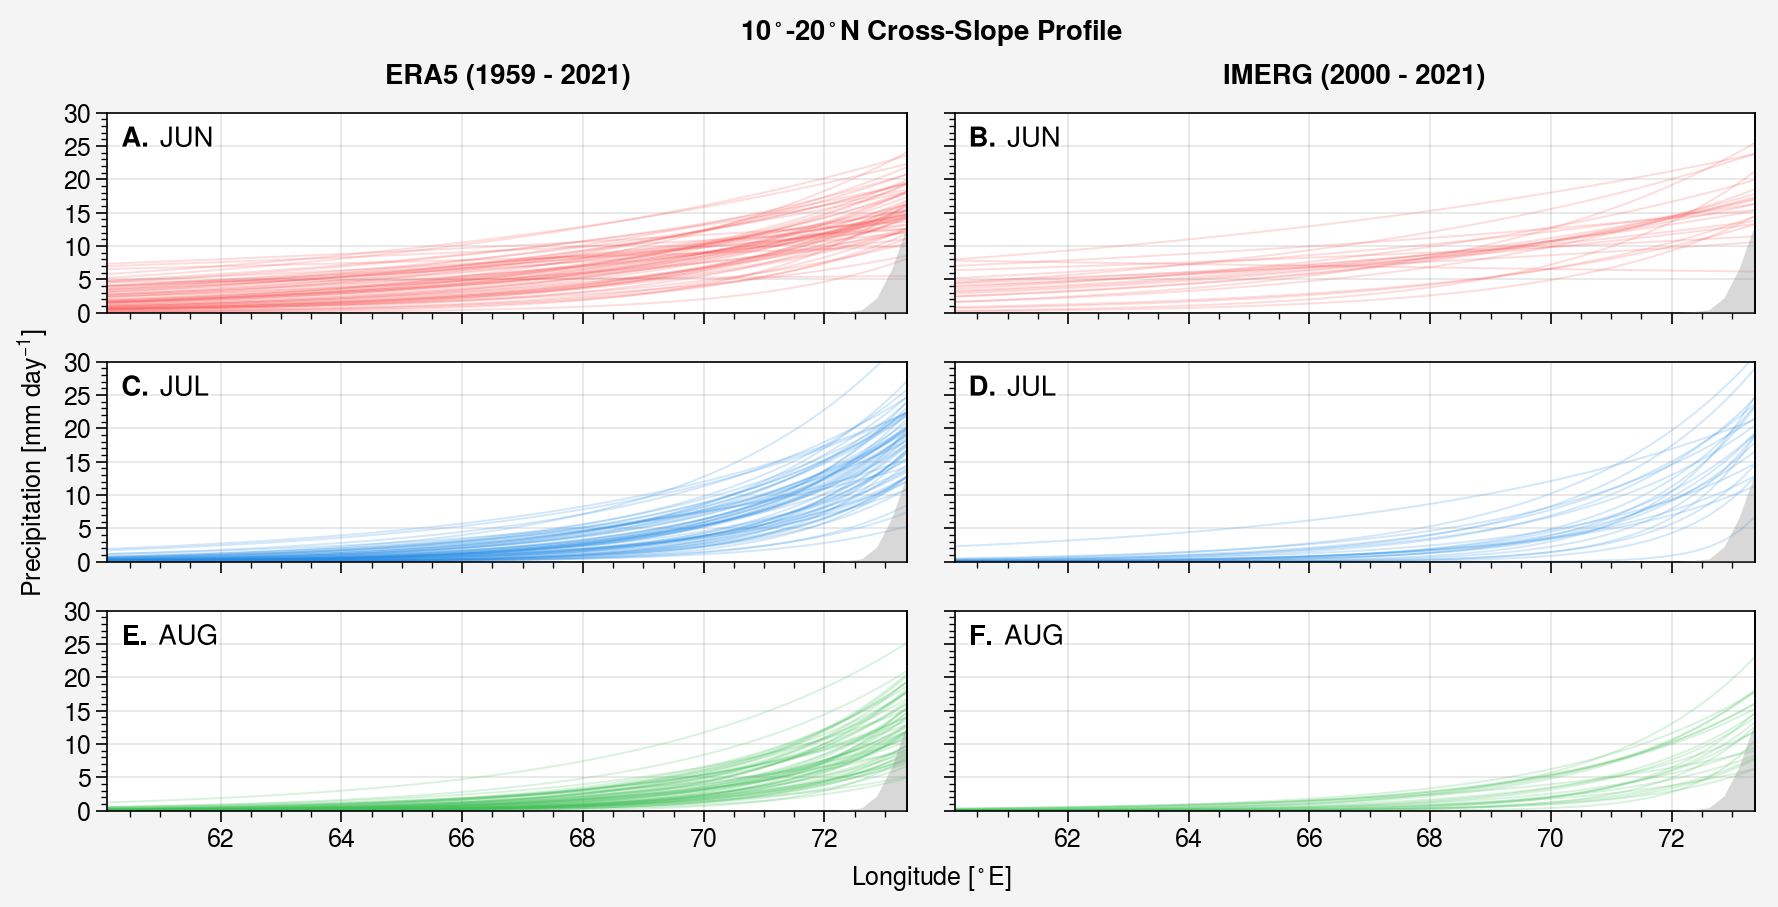

In [7]:
pplt.rc.reso='hi'; colors=np.asarray(['red6','blue6','green6']); alpha=0.2; linewidth=0.7
fig,axs = pplt.subplots(ncols=2,nrows=3,refwidth=4,refheight=1)
axs.format(suptitle=str(lat1)+'$^\circ$-'+str(lat2)+'$^\circ$N Cross-Slope Profile',
           abc='A.',abcloc='ul',collabels=names,
           xlabel='Longitude [$^\circ$E]',xticks=2,
           ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,30),yticks=5,) 
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylim=(0,0.2),ylabel='',yticks='null')
for i,ax in enumerate(months):    
    for j in range(era5years):    
        axs[2*i].plot(lon,era5fittedpr[i,j],color=colors[i],alpha=alpha,linewidth=linewidth)
        axs[2*i].format(titleloc='ul',title=months[i])
    for k in range(imergyears):   
        axs[2*i+1].plot(lon,imergfittedpr[i,k],color=colors[i],alpha=alpha,linewidth=linewidth)
        axs[2*i+1].format(titleloc='ul',title=months[i])

## Plot Correlations Between Actual and Fitted Upwind Precipitation

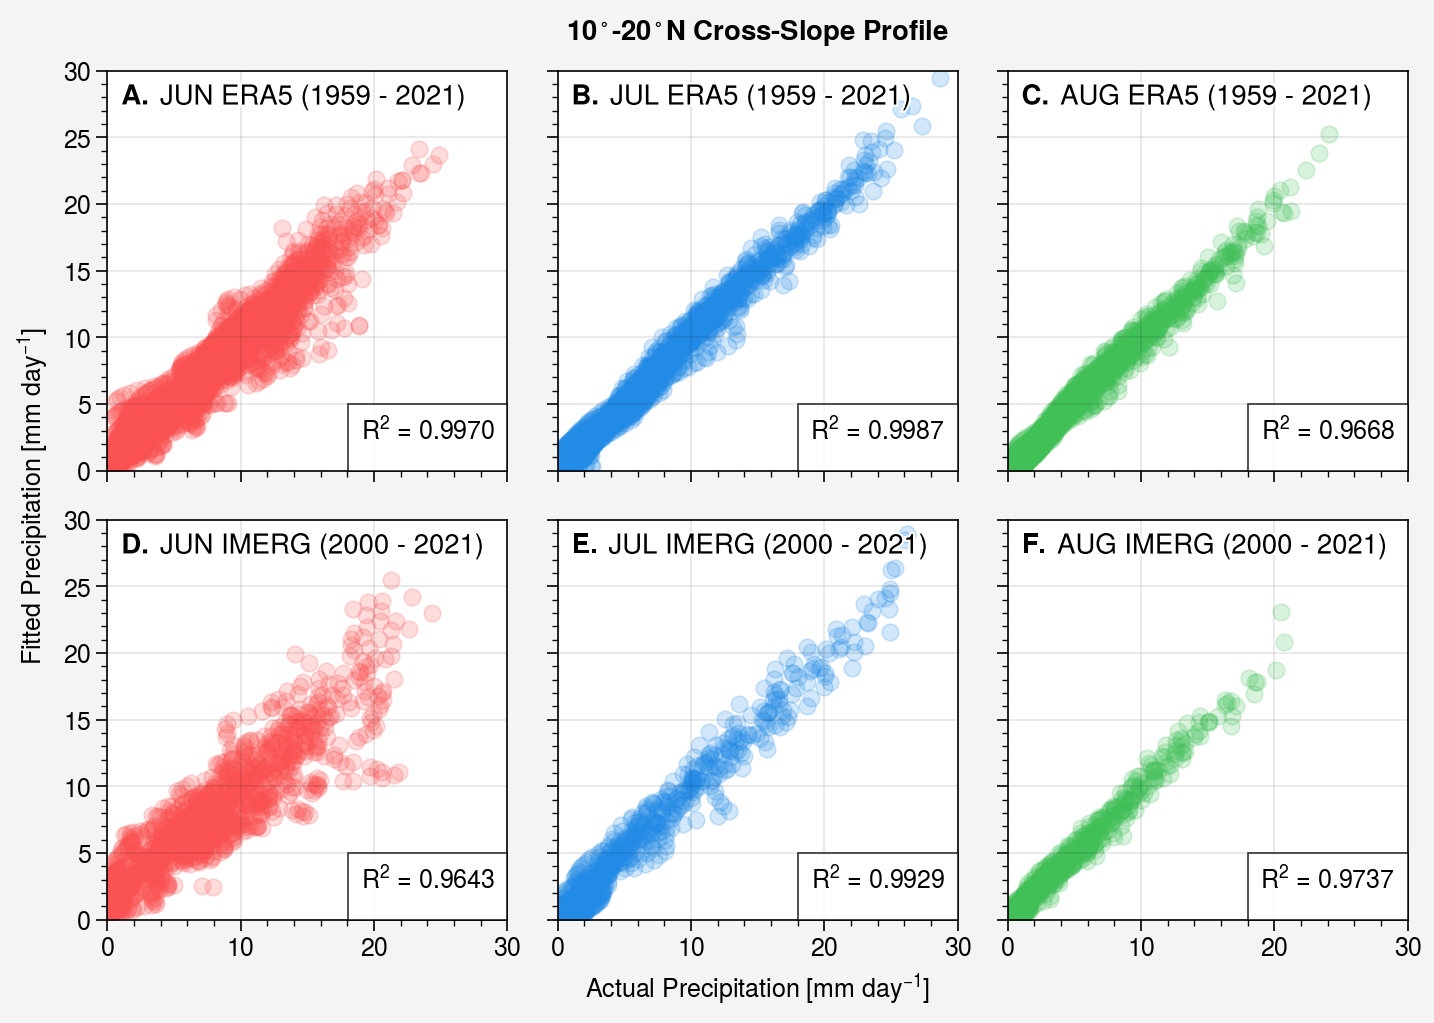

In [8]:
pplt.rc.reso='hi'; colors=np.asarray(['red6','blue6','green6']); alpha=0.2
fig,axs = pplt.subplots(ncols=3,nrows=2,refheight=2,refwidth=2)
axs.format(suptitle=str(lat1)+'$^\circ$-'+str(lat2)+'$^\circ$N Cross-Slope Profile',abc='A.',abcloc='ul',
           xlabel='Actual Precipitation [mm day$^{-1}$]',xlim=(0,30),
           ylabel='Fitted Precipitation [mm day$^{-1}$]',ylim=(0,30)) 
for i,ax in enumerate(months):    
    for j in range(era5years):      
        axs[i].scatter(era5pr[i,j],era5fittedpr[i,j],colors=colors[i],alpha=alpha)
        axs[i].format(titleloc='ul',title=months[i]+' ERA5 (1959 - 2021)') 
    axs[i].legend(loc='lr',label='$R^2$ = '+str('{:.4f}'.format((r2_score(era5pr[i,j],era5fittedpr[i,j])))))
    for k in range(imergyears):      
        axs[i+3].scatter(imergpr[i,k],imergfittedpr[i,k],colors=colors[i],alpha=alpha)
        axs[i+3].format(titleloc='ul',title=months[i]+' IMERG (2000 - 2021)') 
    axs[i+3].legend(loc='lr',label='$R^2$ = '+str('{:.4f}'.format((r2_score(imergpr[i,k],imergfittedpr[i,k])))))